In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import time
import nfl_model
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
csv_data_path = '..\Data\playbyplaydata\*.csv'
X_train, X_test, y_train, y_test = nfl_model.gather_and_process_data(csv_data_path, test_season=2016)

print('X_train: {}'.format(len(X_train)))
print('y_train: {}'.format(len(y_train)))
print('')
print('X_test : {}'.format(len(X_test)))
print('y_test : {}'.format(len(y_test)))
print('')
print('X_Total: {}'.format(len(X_train)+len(X_test)))
print('y_Total: {}'.format(len(y_test)+len(y_train)))



X_train: 255908
y_train: 255908

X_test : 36519
y_test : 36519

X_Total: 292427
y_Total: 292427


# Building a Random Forest Classification Model for NFL Decisions

## Game Time Decisions
Its 1st and Goal with less than a minute on the clock in the 4th quarter. Your team is down by 3 points, what do you do? Should you run the ball hoping to break into the endzone? What about passing the ball instead? Or should you go for the field goal just to get the tie. Everyone has an opinion on various NFL scenarios but we will build a model that tells you which decision the pros would make given the same situation.


### Data
To build our predictive model we first need some data. The NFL has released play by play information for every game since 2009. We can look at the features of each play to predict what the ultimate play decision was. Given that a play can have many different intended outcomes we will need to build a supervised classification model. 

### Inputs
From the NFL play-by-play data we can use the following info from each play as inputs to our RF model.
* Quarter 
* Time Remaining
* Down
* Yards to 1st Down
* Field Position
* Score

### Output
The RF model will be able to return a probability estimation for what the best decision would be for a given set of inputs (NFL situation). The possible play types would be the following:
* Pass
* Run
* Punt
* Field Goal
* QB Kneel

### Disclamer!
This model is designed to favor the "average" NFL decision for a given situation. It does not look to see if this decision will result in a positive outcome however since all historical decisions by NFL teams are made under the desire for a positive outcome so the model should reflect that desire as well. Stronger models utilizing more features of the data that indicate play success or failure could be built from the same dataset.

## Train/Test Data
For this model we will split our data into train and test data by season. The model will train using data from the 2009-2015 seasons and then will be tested on the 2016 season.

## Random Forest Model Tuning
  
#### Min_samples_leaf
Lets tune the *min_samples_leaf* parameter.  

We expect the smaller values to take more time since it means we are allowing the trees to terminate only once 'x' samples remain in a leaf's data subset. It will take more splits and decisions to make leaves with samples of 1 vs 300. It may also lead to overfitting at lower values since more decisions are being forced in each tree on smaller subsets of data. If the value is too large the model will build much quicker but it will not have made enough decisions in it's trees to get a deep enough look into the data and ultimately will miss some key indicators.

We will build and test the model for the following parameters and then plot each one's score to see it's impact on model performance:  
*[1,3,6,9,12,15,18,22,25,50,75,100,125,150,175,200,225,250,275,300]*



In [6]:
# Testing "min_samples_leaf"
min_samples_leaf = [1,3,6,9,12,15,18,22,25,50,75,100,125,150,175,200,225,250,275,300]
n_estimators = [30]

min_samples_leaf_scores = []
for n in n_estimators:
    print('-' * 40)
    for l in min_samples_leaf:
        print('--- Testing', '({},{})'.format(n,l))
        start = time.time()
        rfc = nfl_model.build_random_forest_model(
            X_train,
            y_train,
            n_estimators=n, 
            max_depth=None, 
            min_samples_split=2, 
            min_samples_leaf=l, 
            max_features='auto',  
            bootstrap=True, 
            oob_score=True, 
            n_jobs=-1, 
            random_state=0
        )
        stop = time.time()
        score = rfc.score(X_test, y_test)
        run_time = stop - start
        min_samples_leaf_scores.append([n, l, score, run_time])
        print('     Run Time: ', run_time)
        print('     Score:    ', score)

----------------------------------------
--- Testing (30,1)
     Run Time:  6.252677917480469
     Score:     0.673594567212
--- Testing (30,3)
     Run Time:  5.5502588748931885
     Score:     0.695391440072
--- Testing (30,6)
     Run Time:  5.391090631484985
     Score:     0.701196637367
--- Testing (30,9)
     Run Time:  5.45693302154541
     Score:     0.704071853008
--- Testing (30,12)
     Run Time:  5.262301921844482
     Score:     0.705660067362
--- Testing (30,15)
     Run Time:  5.092943906784058
     Score:     0.705796982393
--- Testing (30,18)
     Run Time:  4.89443039894104
     Score:     0.703962320984
--- Testing (30,22)
     Run Time:  5.026628732681274
     Score:     0.707056600674
--- Testing (30,25)
     Run Time:  4.9804534912109375
     Score:     0.707768558832
--- Testing (30,50)
     Run Time:  4.789234161376953
     Score:     0.708507899997
--- Testing (30,75)
     Run Time:  4.766742467880249
     Score:     0.708754347052
--- Testing (30,100)
     Ru

In [7]:
sns.set_context('talk')
sns.set_style('ticks')

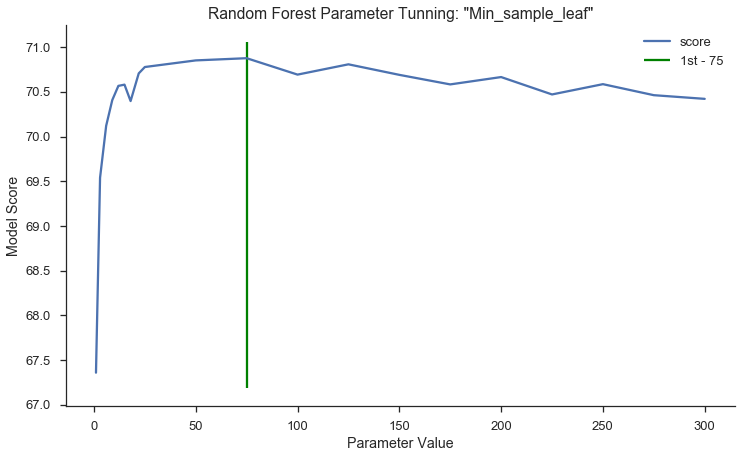

In [8]:
records = [{'n':x[0], 'l':x[1], 'score':x[2]*100, 'time':x[3]} for x in min_samples_leaf_scores]
results_df = pd.DataFrame.from_records(records)
fig,ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(results_df.l, results_df.score)
ax.set_title('Random Forest Parameter Tunning: "Min_sample_leaf"')
ax.set_xlabel('Parameter Value')
ax.set_ylabel('Model Score')
sns.despine()
ax.vlines(x=75,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],colors='g', label='1st - 75')
ax.legend()
plt.show()


The testing shows the model performs poorly with "min_samples_leaf" values below 20 compared to values above 20.  
The highest tested mark occurs at a value of **75** which we will use in the final model.

#### N_estimators
Next up lets tune the *N_estimators* parameter.  

We expect the smaller values to take less time since we are requiring less trees to be made. The larger we can make this value the better however since more estimators is not going to hurt our model. More models do eventually take too much time/memory to easily compute. 

We will build and test the model for the following parameters and then plot each one's score to see it's impact on model performance:  
*[30,50,75,100,125,150,175,200,250,300]*

In [9]:
# Testing "n_estimators"
min_samples_leaf = [75]
n_estimators = [30,50,75,100,125,150,175,200,250,300]

n_estimator_scores = []
for n in n_estimators:
    print('-' * 40)
    for l in min_samples_leaf:
        print('--- Testing', '({},{})'.format(n,l))
        start = time.time()
        rfc = nfl_model.build_random_forest_model(
            X_train,
            y_train,
            n_estimators=n, 
            max_depth=None, 
            min_samples_split=2, 
            min_samples_leaf=l, 
            max_features='auto',  
            bootstrap=True, 
            oob_score=True, 
            n_jobs=-1, 
            random_state=0
        )
        stop = time.time()
        score = rfc.score(X_test, y_test)
        run_time = stop - start
        n_estimator_scores.append([n, l, score, run_time])
        print('     Run Time: ', run_time)
        print('     Score:    ', score)

----------------------------------------
--- Testing (30,75)
     Run Time:  4.877823829650879
     Score:     0.708754347052
----------------------------------------
--- Testing (50,75)
     Run Time:  7.930446624755859
     Score:     0.709055560119
----------------------------------------
--- Testing (75,75)
     Run Time:  11.681257247924805
     Score:     0.708781730058
----------------------------------------
--- Testing (100,75)
     Run Time:  15.534529209136963
     Score:     0.708617432022
----------------------------------------
--- Testing (125,75)
     Run Time:  18.990514993667603
     Score:     0.708562666009
----------------------------------------
--- Testing (150,75)
     Run Time:  22.70390272140503
     Score:     0.708124537912
----------------------------------------
--- Testing (175,75)
     Run Time:  26.98220920562744
     Score:     0.708398367973
----------------------------------------
--- Testing (200,75)
     Run Time:  30.68756341934204
     Score:    

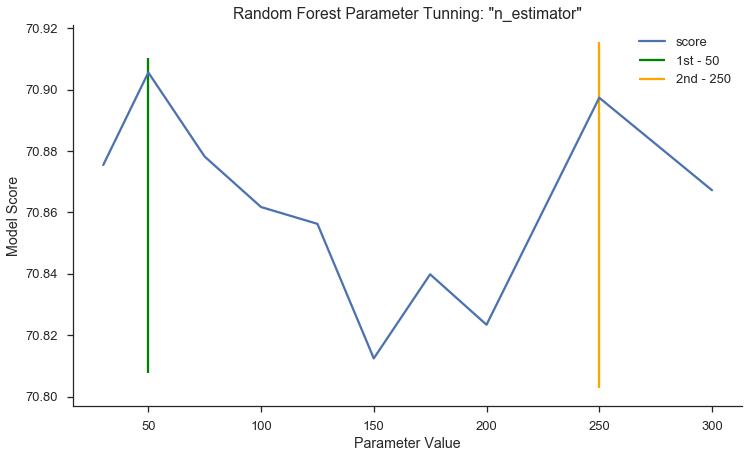

In [14]:
records = [{'n':x[0], 'l':x[1], 'score':x[2]*100, 'time':x[3]} for x in n_estimator_scores]
results_df = pd.DataFrame.from_records(records)
fig,ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(results_df.n, results_df.score)
ax.set_title('Random Forest Parameter Tunning: "n_estimator"')
ax.set_xlabel('Parameter Value')
ax.set_ylabel('Model Score')
sns.despine()
ax.vlines(x=50,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],colors='green', label = '1st - 50')
ax.vlines(x=250,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],colors='orange', label = '2nd - 250')
ax.legend()
plt.show()

Given the overall range of model score values to fall within 0.1 the number of estimators is not showing significant change to the model performance. A test was also done at 1000 estimators with a value in line with the above results. We will use a value of **250** n_estimators since the high score at 50 n_estimators could be a result of statistical randomness. The value of 250 strikes a good balance between computation time and statistical rigor.

In [4]:
winning_rfc = nfl_model.build_random_forest_model(
                X_train,
                y_train,
                n_estimators=250, 
                max_depth=None, 
                min_samples_split=2, 
                min_samples_leaf=75, 
                max_features='auto',  
                bootstrap=True, 
                oob_score=True, 
                n_jobs=-1, 
                random_state=0
            )

In [5]:
winning_rfc.score(X_test, y_test)

0.70897341110107071

# Using the model


### Model Score - 70.9%
After tuning our model we get a 2016 prediction score of **70.9%**. So nearly 3 out of 4 plays were predicted correctly. Based on this it would make good sense to return the probability estimates for each decision when using the model so you can see what the next closest decision was since it is likely that many of these situations have multiple outcomes that different teams tend to use more often than the next. Stronger models using more features can capitalize on this and build a more robust predictor given individual team/player information.

In [6]:
qtr = 4
down = 3
ydstogo = 10
TimeUnder = 1
yrdline100 = 40
ScoreDiff = 7

test_case = [[qtr, down, ydstogo, TimeUnder, yrdline100, ScoreDiff]]
classes = winning_rfc.classes_
rfcp = winning_rfc.predict_proba(test_case)[0]*100

rfcp = [str(round(x,2)) for x in rfcp]

print("")
print("Random Forest")
for item in zip(classes,rfcp):
    print(item)




Random Forest
('Field Goal', '1.88')
('Pass', '25.37')
('Punt', '0.68')
('QB Kneel', '43.59')
('Run', '28.48')


In [7]:
nfl_model.store_model(winning_rfc,'random_forest_classifier')